In [15]:
# Clone the repo (safe to re-run if it already exists)
import os

if not os.path.exists("Loan-Approval-Prediction---New-York---2025"):
    !git clone https://github.com/remussamoila/Loan-Approval-Prediction---New-York---2025.git

%cd Loan-Approval-Prediction---New-York---2025

# ✅ List folders to confirm structure
import os
os.listdir()

Cloning into 'Loan-Approval-Prediction---New-York---2025'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 166 (delta 4), reused 3 (delta 3), pack-reused 160 (from 1)
Receiving objects: 100% (166/166), 2.64 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/Loan-Approval-Prediction---New-York---2025/Loan-Approval-Prediction---New-York---2025/Loan-Approval-Prediction---New-York---2025/Loan-Approval-Prediction---New-York---2025/Loan-Approval-Prediction---New-York---2025


['docs', 'data', 'notebooks', 'models', '.git', 'README.md']


# ⚙️ Advanced Modeling - Loan Approval



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/remussamoila/Loan-Approval-Prediction---New-York---2025/blob/main/notebooks/04_advanced_models.ipynb)

# 📘 04_advanced_models.ipynb

**Goal**: Train and compare advanced models (XGBoost and LightGBM) for the SME Loan Approval task. Evaluate with Mean F1 Score.

This notebook includes:
- Data loading and preprocessing
- Training XGBoost and LightGBM
- Hyperparameter tuning (GridSearchCV)
- Model comparison and export

In [16]:
# ✅ Step 1: Load libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# ✅ Step 2: Load and preprocess data
df = pd.read_csv('data/train.csv', low_memory=False)
df['DisbursementGross'] = df['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)
df['BalanceGross'] = df['BalanceGross'].replace('[\$,]', '', regex=True).astype(float)
df.drop(columns=['id', 'LoanNr_ChkDgt', 'Name', 'City', 'DisbursementDate', 'ApprovalDate'], inplace=True)
df.fillna(-1, inplace=True)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])
X = df.drop(columns=['Accept'])
y = df['Accept']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# ✅ Step 2B: Train Baseline Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Dummy Classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
f1_dummy = f1_score(y_val, dummy.predict(X_val))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
f1_lr = f1_score(y_val, lr.predict(X_val))

# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
f1_tree = f1_score(y_val, tree.predict(X_val))

print("📊 Dummy F1:", f1_dummy)
print("📊 Logistic Regression F1:", f1_lr)
print("📊 Decision Tree F1:", f1_tree)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 Dummy F1: 0.8866220966296782
📊 Logistic Regression F1: 0.8859606760952052
📊 Decision Tree F1: 0.8553617927878167


In [19]:
# ✅ Step 3: Train XGBoost
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_val)
f1_xgb = f1_score(y_val, y_pred_xgb)
print('XGBoost F1 Score:', f1_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost F1 Score: 0.9110799024318131


In [20]:
# ✅ Step 4: Train LightGBM
model_lgb = LGBMClassifier(random_state=42)
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_val)
f1_lgb = f1_score(y_val, y_pred_lgb)
print('LightGBM F1 Score:', f1_lgb)

[LightGBM] [Info] Number of positive: 25729, number of negative: 6579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 32308, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796366 -> initscore=1.363736
[LightGBM] [Info] Start training from score 1.363736
LightGBM F1 Score: 0.9136038889298078


In [21]:
# ✅ Step 5A: Hyperparameter Tuning (XGBoost)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                        param_grid_xgb, scoring='f1', cv=3)
grid_xgb.fit(X_train, y_train)
print('Best XGBoost params:', grid_xgb.best_params_)
print('Best XGBoost F1:', grid_xgb.best_score_)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best XGBoost params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
Best XGBoost F1: 0.9105689395874476


In [22]:
# ✅ Step 5B: Hyperparameter Tuning (LightGBM)
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}
grid_lgb = GridSearchCV(LGBMClassifier(), param_grid_lgb, scoring='f1', cv=3)
grid_lgb.fit(X_train, y_train)
print('Best LightGBM params:', grid_lgb.best_params_)
print('Best LightGBM F1:', grid_lgb.best_score_)

[LightGBM] [Info] Number of positive: 17152, number of negative: 4386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 21538, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796360 -> initscore=1.363697
[LightGBM] [Info] Start training from score 1.363697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

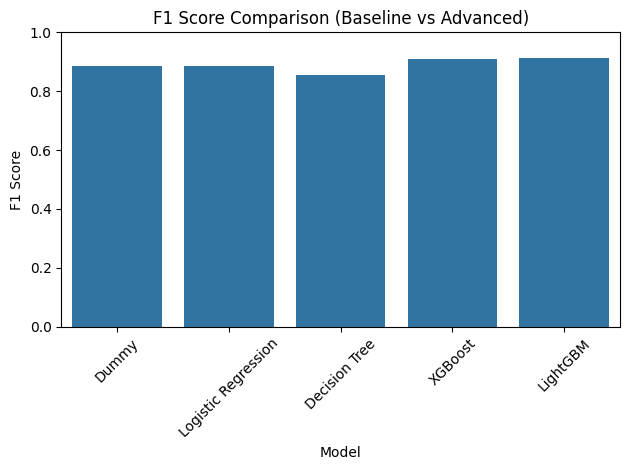

,Model,F1 Score
0,Dummy,0.886622
1,Logistic Regression,0.885961
2,Decision Tree,0.855362
3,XGBoost,0.911080
4,LightGBM,0.913604


In [23]:
# ✅ Step 6: Compare Models
results = pd.DataFrame({
    'Model': ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'LightGBM'],
    'F1 Score': [f1_dummy, f1_lr, f1_tree, f1_xgb, f1_lgb]
})
sns.barplot(x='Model', y='F1 Score', data=results)
plt.title('F1 Score Comparison (Baseline vs Advanced)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
results

In [24]:
# ✅ Step 7: Export the best model
import joblib

# Assuming LightGBM gave the best results — adjust if needed
best_model = model_lgb if f1_lgb > f1_xgb else model_xgb
joblib.dump(best_model, 'models/best_model.joblib')
print("✅ Best model saved to models/best_model.joblib")

✅ Best model saved to models/best_model.joblib
